In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '//content/drive/MyDrive/Taiwan Plate.v3i.voc.zip' -d '/content'

In [ ]:
!unzip '/content/Taiwan Plate.v3i.voc.zip' -d '/content'

In [2]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 18 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 3s (1,805 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [59]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
import os
import shutil
from tqdm import tqdm
import yaml
import matplotlib.pyplot as plt
import torch
import cv2
import pytesseract as pt
%matplotlib inline

In [60]:
filenames = []

size_props = {
    'height':[],
    'width':[]
}

bounding_box_props = {
    'xmin':[],
    'ymin':[],
    'xmax':[],
    'ymax':[]
}

In [67]:
annotations_path = '/content/yolov8_detection-plates-39/test/labels'
for file in tqdm(os.listdir(annotations_path)):
    annotation = ET.parse(os.path.join(annotations_path, file))
    filenames.append(os.path.join(annotations_path, file))
    size = annotation.find('size')
    for name, prop_list in size_props.items():
        prop_value = size.find(name).text
        size_props[name].append(int(prop_value))
    bounding_box = annotation.find('object').find('bndbox')
    for name, prop_list in bounding_box_props.items():
        prop_value = bounding_box.find(name).text
        bounding_box_props[name].append(int(prop_value))

  0%|          | 0/11 [00:00<?, ?it/s]


ParseError: ignored

In [ ]:
df = pd.DataFrame({
    'file':filenames,
    'width':size_props['width'],
    'height':size_props['height'],
    'xmin':bounding_box_props['xmin'],
    'ymin':bounding_box_props['ymin'],
    'xmax':bounding_box_props['xmax'],
    'ymax':bounding_box_props['ymax']
})

In [ ]:
df.head()

,file,width,height,xmin,ymin,xmax,ymax
0,../content/Taiwan Plate.v3i.voc/labels/car149_...,640,640,28,283,450,402
1,../content/Taiwan Plate.v3i.voc/labels/car015_...,640,640,208,320,470,413
2,../content/Taiwan Plate.v3i.voc/labels/car070_...,640,640,147,368,266,463
3,../content/Taiwan Plate.v3i.voc/labels/car038_...,640,640,227,394,389,460
4,../content/Taiwan Plate.v3i.voc/labels/car068_...,640,640,268,242,336,298


In [ ]:
df['center_x'] = (df['xmax'] + df['xmin'])/(2*df['width'])
df['center_y'] = (df['ymax'] + df['ymin'])/(2*df['height'])

df['bb_width'] = (df['xmax'] - df['xmin'])/df['width']
df['bb_height'] = (df['ymax'] - df['ymin'])/df['height']

In [ ]:
df.head()

,file,width,height,xmin,ymin,xmax,ymax,center_x,center_y,bb_width,bb_height
0,../content/Taiwan Plate.v3i.voc/labels/car149_...,640,640,28,283,450,402,0.373437,0.535156,0.659375,0.185938
1,../content/Taiwan Plate.v3i.voc/labels/car015_...,640,640,208,320,470,413,0.529687,0.572656,0.409375,0.145313
2,../content/Taiwan Plate.v3i.voc/labels/car070_...,640,640,147,368,266,463,0.322656,0.649219,0.185938,0.148438
3,../content/Taiwan Plate.v3i.voc/labels/car038_...,640,640,227,394,389,460,0.481250,0.667188,0.253125,0.103125
4,../content/Taiwan Plate.v3i.voc/labels/car068_...,640,640,268,242,336,298,0.471875,0.421875,0.106250,0.087500


In [ ]:
df.to_csv('platev3_row.csv',index=False)

In [ ]:
# Keeping important columns only
yolo_df = df[['file', 'center_x', 'center_y', 'bb_width', 'bb_height']]
# Performing 70-15-15 split
test_size = int(0.15 * len(df))

df_train, df_test = train_test_split(yolo_df, test_size=test_size)
df_train, df_val = train_test_split(df_train, test_size=test_size)

In [ ]:
train_path = os.path.join('Images_plate', 'train')
val_path = os.path.join('Images_plate','val')
test_path = os.path.join('Images_plate', 'test')
images_path = '../content/Taiwan Plate.v3i.voc/images'

if not os.path.exists(train_path):
    os.makedirs(train_path)
    print('Made folder for train set')

if not os.path.exists(val_path):
    os.makedirs(val_path)
    print('Made folder for val set')

if not os.path.exists(test_path):
    os.makedirs(test_path)
    print('Made folder for test set')

Made folder for train set
Made folder for val set
Made folder for test set


In [ ]:
print('Moving images for train set')
for _, row  in tqdm(df_train.iterrows()):
    annotation_path = row['file']
    image_name = os.path.split(annotation_path)[-1].replace('.xml','')
    image_src = os.path.join(images_path, f'{image_name}.jpg')
    image_dst = os.path.join(train_path, f'{image_name}.jpg')
    shutil.copy2(image_src, image_dst)
    label_text = f"0 {row['center_x']} {row['center_y']} {row['bb_width']} {row['bb_height']}"
    with open(os.path.join(train_path, f'{image_name}.txt'), 'w') as f:
        f.write(label_text)
print('Done moving images for train set')

print('Moving images for val set')
for _, row  in tqdm(df_val.iterrows()):
    annotation_path = row['file']
    image_name = os.path.split(annotation_path)[-1].replace('.xml','')
    image_src = os.path.join(images_path, f'{image_name}.jpg')
    image_dst = os.path.join(val_path, f'{image_name}.jpg')
    shutil.copy2(image_src, image_dst)
    label_text = f"0 {row['center_x']} {row['center_y']} {row['bb_width']} {row['bb_height']}"
    with open(os.path.join(val_path, f'{image_name}.txt'), 'w') as f:
        f.write(label_text)
print('Done moving images for val set')

print('Moving images for test set')
for _, row  in tqdm(df_test.iterrows()):
    annotation_path = row['file']
    image_name = os.path.split(annotation_path)[-1].replace('.xml','')
    image_src = os.path.join(images_path, f'{image_name}.jpg')
    image_dst = os.path.join(test_path, f'{image_name}.jpg')
    shutil.copy2(image_src, image_dst)
    label_text = f"0 {row['center_x']} {row['center_y']} {row['bb_width']} {row['bb_height']}"
    with open(os.path.join(test_path, f'{image_name}.txt'), 'w') as f:
        f.write(label_text)
print('Done moving images for test set')

Moving images for train set


163it [00:00, 2207.26it/s]


Done moving images for train set
Moving images for val set


34it [00:00, 2117.99it/s]


Done moving images for val set
Moving images for test set


34it [00:00, 2249.99it/s]

Done moving images for test set


In [ ]:
# creating data.yaml file which will be used to train YOLO on custom data
data = {
    'names':['License Plate'],
    'nc':1,
    'train':os.path.abspath(train_path),
    'val':os.path.abspath(val_path)
}

with open('data.yaml', 'w') as f:
    yaml.dump(data, f)

In [4]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="LV4BAfnrjTBn3trLLBQF")
project = rf.workspace("plate-va45e").project("yolov8_detection-plates")
dataset = project.version(39).download("yolov5")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.0.76
    Uninstalling opencv-python-headless-4.8.0.76:
      Successfully uninstalled 

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to yolov8_detection-plates-39 in yolov5pytorch:: 100%|██████████| 604/604 [00:00<00:00, 5222.29it/s]


In [6]:
# Cloning the ultralytics yolo repository
! git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 16000, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 16000 (delta 20), reused 20 (delta 12), pack-reused 15967
Receiving objects: 100% (16000/16000), 14.66 MiB | 14.86 MiB/s, done.
Resolving deltas: 100% (10982/10982), done.


In [7]:
# Installing the dependencies required for YOLO
! pip install -r /content/yolov5/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.6/615.6 kB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.2 MB/s eta 0:00:00


# **Yolov5 train**

In [8]:
import os
import cv2

import torch

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
!zip -r yolov5_train.zip /content/yolov5/runs

In [ ]:
# Training the YOLO model
! python ./yolov5/train.py
--data ./data.yaml
--device=0
--batch-size 10
--epochs 40
--weights /content/yolov5s.pt

train: weights=/content/yolov5s.pt, cfg=, data=./data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=40, batch_size=10, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-225-gbb9706e Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015

In [ ]:
!python ./yolov5/val.py --weights /content/yolov5/runs/train/exp6/weights/best.pt --data ./data.yaml --single-cls  --half

val: data=./data.yaml, weights=['/content/yolov5/runs/train/exp6/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=True, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=True, dnn=False
YOLOv5 🚀 v7.0-225-gbb9706e Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/Images_plate/val.cache... 34 images, 0 backgrounds, 0 corrupt: 100% 34/34 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 2/2 [00:02<00:00,  1.34s/it]
                   all         34         34      0.967      0.867      0.978      0.831
Speed: 0.2ms pre-process, 28.3ms inference, 3.1ms NMS per image at shape (32, 3, 640, 640)
Results saved to yolov5/runs/

In [ ]:
# Fetching the latest runs
yolo_path = '/content/train_val2'
latest_run = os.listdir(yolo_path)[-1]

# Fetching the best weights
best_weights = os.path.join(yolo_path, latest_run, 'weights', 'best.pt')

# Loading the model with best weights trained on custom data
model = torch.hub.load('ultralytics/yolov5', 'custom', best_weights)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-10-1 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [ ]:
df_test.head()

,file,center_x,center_y,bb_width,bb_height
70,../content/Taiwan Plate.v2i.voc/labels/car111_...,0.450781,0.474219,0.732812,0.348438
175,../content/Taiwan Plate.v2i.voc/labels/car182_...,0.539062,0.724219,0.443750,0.167187
98,../content/Taiwan Plate.v2i.voc/labels/car060_...,0.522656,0.420312,0.223438,0.096875
195,../content/Taiwan Plate.v2i.voc/labels/car175_...,0.611719,0.544531,0.701562,0.301563
9,../content/Taiwan Plate.v2i.voc/labels/car078_...,0.479687,0.362500,0.109375,0.081250


In [ ]:
import cv2

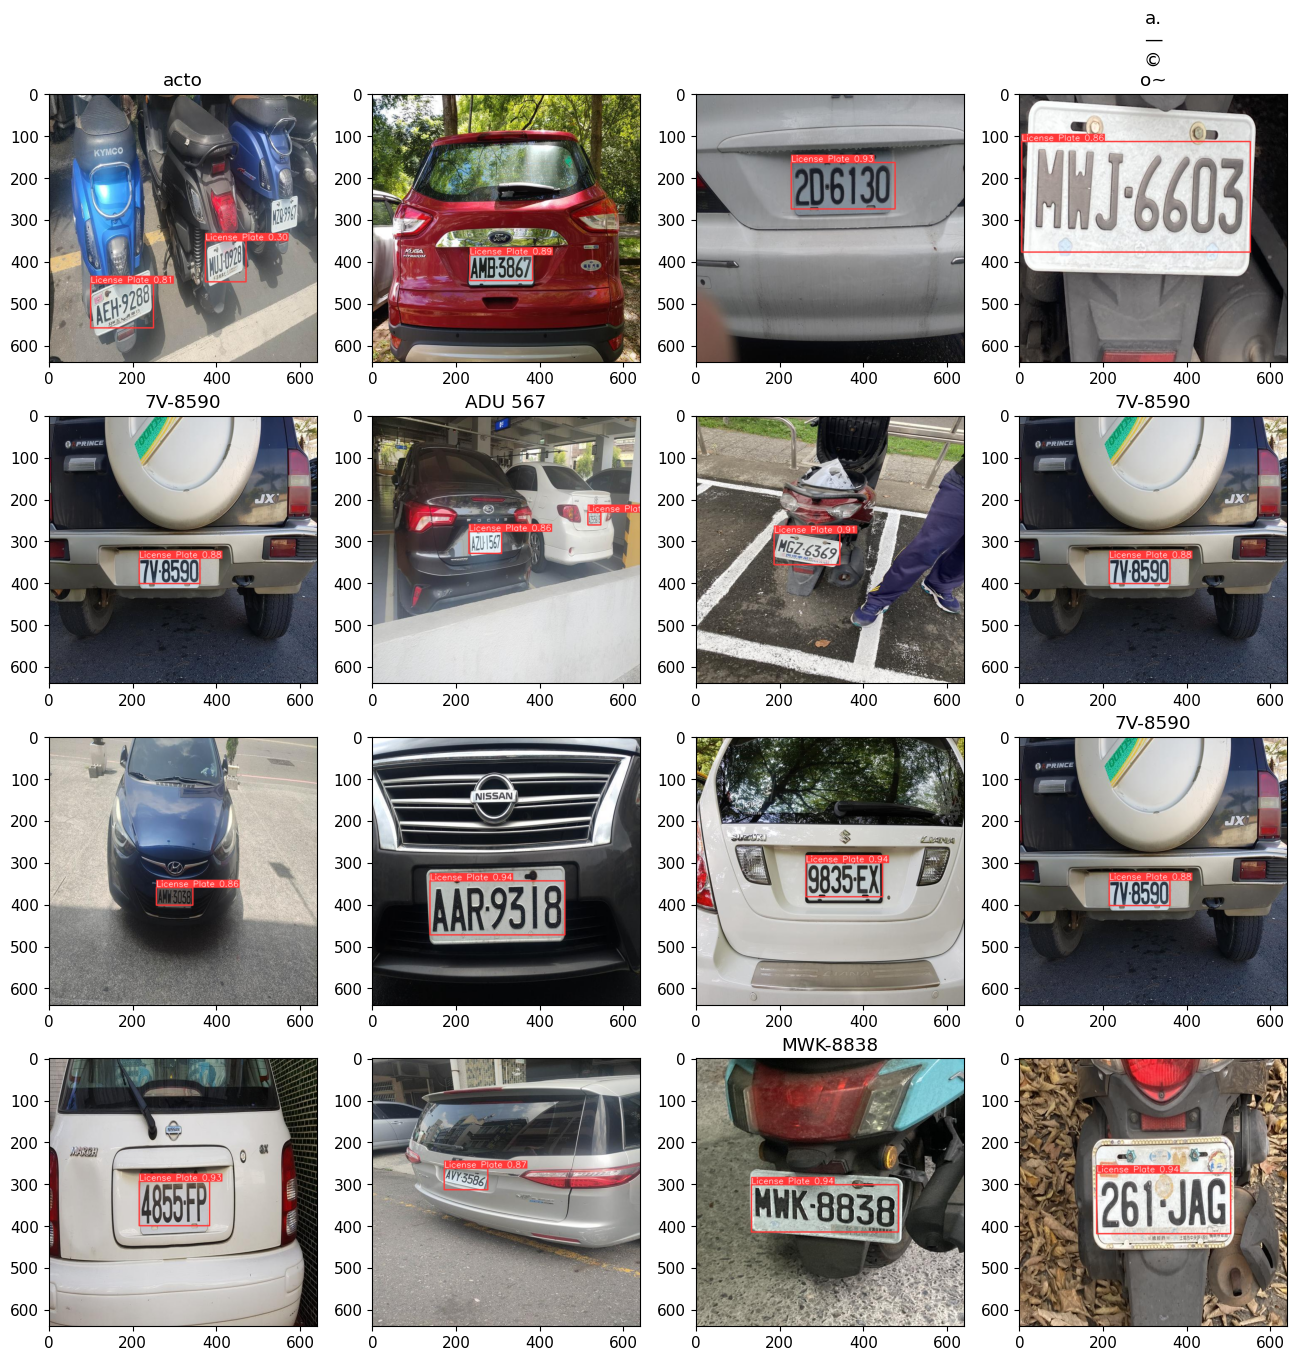

In [ ]:
%matplotlib inline
# Fetching random 16 images from test set
test_files = df_test['file'].apply(lambda x: x.replace('labels','images').replace('xml','jpg'))
test_images = np.random.choice(test_files, size=(4,4))

# Visualizing predictions
fig, ax = plt.subplots(figsize=(16,16), nrows=4, ncols=4)
for i in range(4):
    for j in range(4):
        # Reading the image
        image = cv2.imread(test_images[i,j])
        # Convert image to RGB colorspace
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Predicting from model
        results = model(image)
        # Getting co ordinates of license plate
        results_df = results.pandas().xyxy[0].loc[0]
        x_min = int(results_df['xmin'])
        x_max = int(results_df['xmax'])
        y_min = int(results_df['ymin'])
        y_max = int(results_df['ymax'])
        # Cropping license plate from image ""
        number_plate = image[y_min:y_max,x_min:x_max]
        # Performing OCR on image
        text = pt.image_to_string(number_plate)
        # Showing the results
        ax[i,j].set_title(str(text).strip())
        ax[i,j].imshow(np.squeeze(results.render()))
plt.show()

# **Save Yolov5 plate.csv**

In [ ]:
df_train.to_csv('df_train.csv',index=False)

In [ ]:
df_val.to_csv('df_val.csv',index=False)

In [ ]:
df_test.to_csv('df_test.csv',index=False)